In [1]:
import pandas as pd
import numpy as np
from transformers import pipeline
from modules.tweet_data import read_raw_data, clean_sentiment
from modules.spacy import spacy_twitter_model
import datetime as dt
import time
import pickle

pd.options.mode.chained_assignment = None  # default='warn'

In [11]:
# sentiment-analysis uses model 'distilbert-base-uncased-finetuned-sst-2-english'
# https://huggingface.co/transformers/_modules/transformers/pipelines.html#TextClassificationPipeline
sentiment_model = pipeline('sentiment-analysis', device=0)

In [3]:
tweet_df = read_raw_data()
#tweet_df = tweet_df['2020-02-01':'2020-02-10']
tweet_df.tweet = clean_sentiment(tweet_df.tweet)

Reading data
Filtering link
Filtering piclink
Filtering hashtag
Filtering email
Filtering add


In [15]:
sentiment = tweet_df[['tweet_id','handle']].copy()
sentiment['sentiment'] = 0
sentiment['score'] = 0

In [16]:
t = time.time()
batch_size = 16
for i in range(0,len(tweet_df),batch_size):
    if i%10000 == 0:
        print("{}/{}, time {:.2f}".format(i, len(tweet_df),(time.time() - t)/60),end="\r")
    sentiment_dict = sentiment_model(tweet_df.tweet.iloc[i:i+batch_size].to_list())
    sentiment.sentiment.iloc[i:i+batch_size] = [1 if d['label'] == 'POSITIVE' else -1 for d in sentiment_dict]
    sentiment.score.iloc[i:i+batch_size] = [d['score'] for d in sentiment_dict]
    
print("{}/{}, time {:.2f}".format(i, len(tweet_df),(time.time() - t)/60),end="\r")

In [17]:
pickle.dump( sentiment, open( "sentiment.p", "wb" ) )

Sentiment stats:
    
Average sentiment
Avg sentiment by person
Avg sentiment by non fintwit?
Average sentiment by fintwit
Average sentiment by trader

When fitting market, can we find the most predictive twitters

In [ ]:
sentiment = pickle.load(open( "data/sentiment.p", "rb" ))
classi = pd.read_csv('data/handle_class.csv')
sentiment = pd.merge(sentiment,classi[['class','handle','subclass']],on=['handle'], right_index=True)
sentiment.head()

In [2]:
es = pd.read_csv('data/spx.csv')
es.Date = pd.to_datetime(es.Date +' ' +'15:45')
es.set_index('Date', inplace=True)
date_range = es['2011-12-30':'2020-5-31'].index
#del es

In [ ]:
def final_score(x):
    return (x.sentiment * x.score).mean()

sentiment_features = pd.DataFrame(index = date_range[1:])
date_bins = pd.cut(sentiment.index, bins=date_range)

# Daily Average
sentiment_features['daily_average'] = sentiment.groupby(date_bins).apply(final_score)

#Average by user class
class_averages = sentiment.groupby([date_bins,'class']).apply(final_score).unstack().add_prefix('daily_average_')
sentiment_features[class_averages.columns] = class_averages
del class_averages

sentiment_features['daily_average_trader'] = sentiment.groupby([date_bins,'subclass']).apply(final_score)[:,'trader']

sentiment_features.head()

In [ ]:
A = pd.DataFrame(index = date_range[1:])
A['avg'] = sentiment.groupby(date_bins).agg('count').tweet_id
A['day_diff'] = 0
A.day_diff.loc[A.index[1:]] = (A.index[1:] - A.index[:-1]).days
for i in [2,3,4,5]:
    ratio = A[A.day_diff == 1].mean()/A[A.day_diff == i].mean()
    A.loc[A.day_diff == i, 'avg'] = (ratio['avg'] * A[A.day_diff == i]['avg']).astype('int')
A = A/A.rolling(200, min_periods=1).mean()
sentiment_features['num_tweets'] = A.avg
sentiment_features.num_tweets.iloc[0:7] = 1
sentiment_features.loc[sentiment_features.num_tweets < 0.8,'num_tweets'] =0.8

In [83]:
sentiment_features.to_csv('data/sentiment_features.csv')

In [13]:
sentiment_features = pd.read_csv('data/sentiment_features.csv')

In [15]:
sentiment_features.Date = pd.to_datetime(sentiment_features.Date)
sentiment_features.Date = sentiment_features.Date.dt.date
sentiment_features.set_index('Date',drop=True, inplace=True)

In [20]:
es.index = es.index.date

In [42]:
mkt

Date
2012-01-03         NaN
2012-01-04         NaN
2012-01-05         NaN
2012-01-06         NaN
2012-01-09         NaN
                ...   
2020-05-22   -0.288797
2020-05-26   -0.286249
2020-05-27   -0.285907
2020-05-28   -0.285485
2020-05-29   -0.284896
Name: daily_average, Length: 2095, dtype: float64

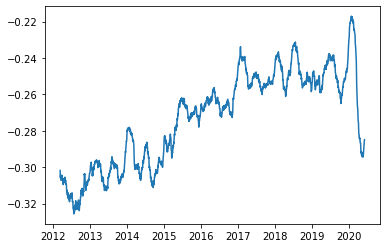

In [46]:
plt.plot(mkt)

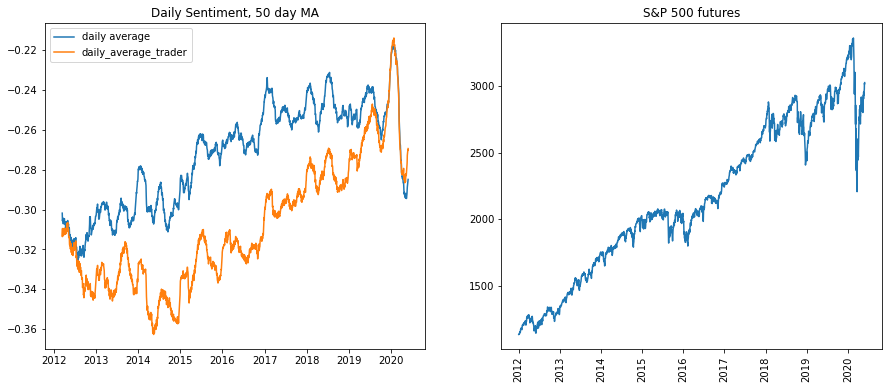

In [107]:
import matplotlib.pyplot as plt

mkt = sentiment_features.daily_average.rolling(50).mean()
mkt2 = sentiment_features.daily_average_trader.rolling(50).mean()

fig, ax = plt.subplots(1,2,figsize=(15,6))
ax[0].plot(mkt, label='daily average')
ax[0].plot(mkt2, label='daily_average_trader')
ax[0].set_title('Daily Sentiment, 50 day MA')

ax[0].legend()

ax[1].plot(es.loc[mkt.index])
ax[1].set_title('S&P 500 futures');



In [79]:
mkt.index = pd.to_datetime(mkt.index)
mkt2.index = pd.to_datetime(mkt2.index)

In [82]:
mkt[pd.to_datetime('2020-01-01'):pd.to_datetime('2020-04-01')]

Date
2020-01-02   -0.168115
2020-01-03   -0.169738
2020-01-06   -0.168351
2020-01-07   -0.168858
2020-01-08   -0.176222
                ...   
2020-03-26   -0.309945
2020-03-27   -0.305520
2020-03-30   -0.301571
2020-03-31   -0.299582
2020-04-01   -0.299400
Name: daily_average, Length: 63, dtype: float64

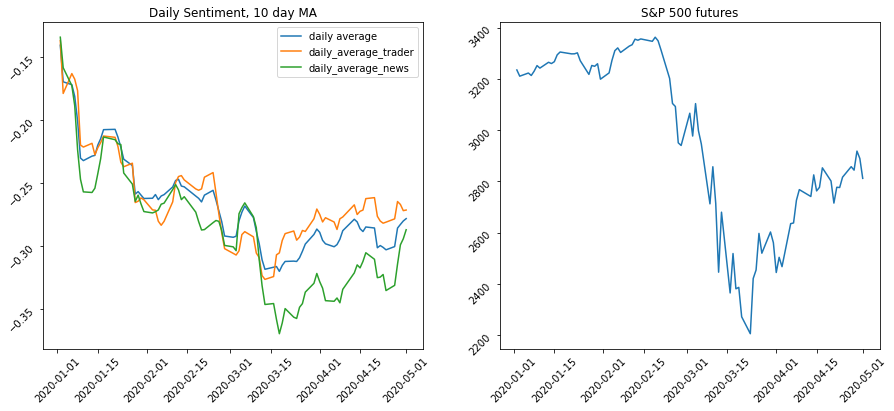

In [116]:
import matplotlib.pyplot as plt

mkt = sentiment_features.daily_average.rolling(5).mean()
mkt2 = sentiment_features.daily_average_trader.rolling(5).mean()
mkt3 = sentiment_features.daily_average_news.rolling(5).mean()


fig, ax = plt.subplots(1,2,figsize=(15,6))
plt.xticks(rotation=90)
ax[0].plot(mkt[pd.to_datetime('2020-01-01'):pd.to_datetime('2020-05-01')], 
           label='daily average')
ax[0].plot(mkt2[pd.to_datetime('2020-01-01'):pd.to_datetime('2020-05-01')], 
           label='daily_average_trader')
ax[0].plot(mkt3[pd.to_datetime('2020-01-01'):pd.to_datetime('2020-05-01')], 
           label='daily_average_news')
ax[0].set_title('Daily Sentiment, 10 day MA')
ax[0].legend()
ax[0].tick_params(labelrotation=45)

ax[1].plot(es.loc[pd.to_datetime('2020-01-01'):pd.to_datetime('2020-05-01')])
ax[1].set_title('S&P 500 futures');
ax[1].tick_params(labelrotation=45)


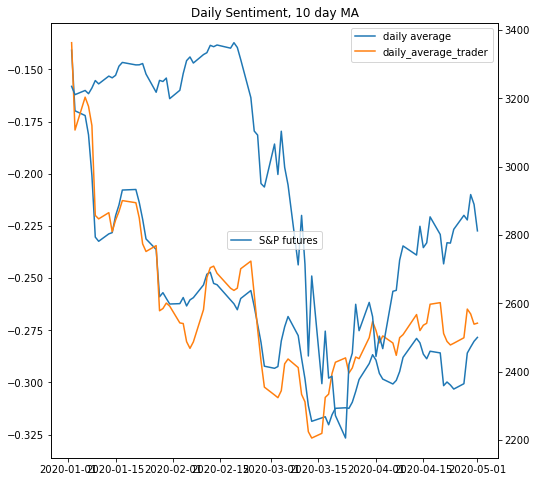

In [103]:
import matplotlib.pyplot as plt

mkt = sentiment_features.daily_average.rolling(5).mean()
mkt2 = sentiment_features.daily_average_trader.rolling(5).mean()

fig, ax = plt.subplots(figsize=(8,8))

ax.plot(mkt[pd.to_datetime('2020-01-01'):pd.to_datetime('2020-05-01')], 
           label='daily average')
ax.plot(mkt2[pd.to_datetime('2020-01-01'):pd.to_datetime('2020-05-01')], 
           label='daily_average_trader')
ax.set_title('Daily Sentiment, 10 day MA')
ax.legend()

ax2 = ax.twinx()

ax2.plot(es.loc[pd.to_datetime('2020-01-01'):pd.to_datetime('2020-05-01')],
        label = 'S&P futures')
ax2.legend(loc=10)

In [ ]:
ax2 = ax1.twinx()

In [16]:
sentiment_features

,daily_average,daily_average_fintwit,daily_average_news,daily_average_politics,daily_average_trader,num_tweets
Date,,,,,,
2012-01-03,-0.175479,-0.178582,-0.191966,-0.146552,-0.154668,1.000000
2012-01-04,-0.266243,-0.334767,-0.166645,-0.239557,-0.336303,1.000000
2012-01-05,-0.337371,-0.384344,-0.291280,-0.243320,-0.368697,1.000000
2012-01-06,-0.325877,-0.355626,-0.321614,-0.214214,-0.354338,1.000000
2012-01-09,-0.252546,-0.257554,-0.255376,-0.235941,-0.223905,1.000000
...,...,...,...,...,...,...
2020-05-22,-0.253020,-0.252198,-0.293804,-0.203445,-0.207843,1.050272
2020-05-26,-0.207086,-0.228573,-0.227329,-0.135577,-0.183169,1.139891
2020-05-27,-0.273786,-0.289272,-0.289738,-0.199586,-0.266116,1.020055


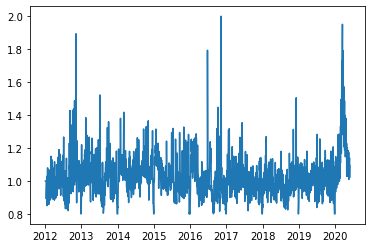

In [82]:
import matplotlib.pyplot as plt
plt.plot(sentiment_features.num_tweets)

In [15]:
sentiment_features_2 = pd.DataFrame(index = date_range[1:])

In [16]:
sentiment_features_2['avg'] = A

In [17]:
sentiment_features_2

,avg
Date,
2012-01-03 15:45:00,1.000000
2012-01-04 15:45:00,0.702148
2012-01-05 15:45:00,0.701487
2012-01-06 15:45:00,0.767855
2012-01-09 15:45:00,1.465593
...,...
2020-05-22 15:45:00,0.868092
2020-05-26 15:45:00,2.257375
2020-05-27 15:45:00,0.837752


In [24]:
sentiment_features_2['day_diff'] = 0
sentiment_features_2.day_diff.loc[sentiment_features_2.index[1:]] = (sentiment_features_2.index[1:] - sentiment_features_2.index[:-1]).days
ratio = sentiment_features_2[sentiment_features_2.day_diff == 1].mean()/sentiment_features_2[sentiment_features_2.day_diff > 1].mean()
sentiment_features_2[sentiment_features_2.day_diff > 1] = ratio * sentiment_features_2[sentiment_features_2.day_diff > 1]





In [25]:
sentiment_features_2

,avg,day_diff
Date,,
2012-01-03 15:45:00,1.000000,0.000000
2012-01-04 15:45:00,0.702148,1.000000
2012-01-05 15:45:00,0.701487,1.000000
2012-01-06 15:45:00,0.767855,1.000000
2012-01-09 15:45:00,0.755523,0.948808
...,...,...
2020-05-22 15:45:00,0.868092,1.000000
2020-05-26 15:45:00,1.163692,1.265077
2020-05-27 15:45:00,0.837752,1.000000


In [9]:
A = pd.DataFrame(range(50,1000))


,0
0,1.000000
1,1.009901
2,1.019608
3,1.029126
4,1.038462
...,...
945,1.111111
946,1.110987
947,1.110864
948,1.110740


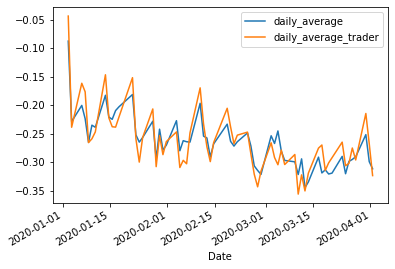

In [9]:
sentiment_features[['daily_average','daily_average_trader']]['2020-01-01':'2020-04-01'].plot()

In [10]:
user_features = sentiment.groupby([date_bins, 'handle']).apply(final_score).unstack()
user_features.index = sentiment_features.index

In [11]:
user_features.head()

handle,4xguy,50Pips,AFP,AJENews,AJEnglish,AJInsight,AP,AaronMehta,AlArabiya_Eng,AlbertoNardelli,...,NickGiva,WildcatTrader,HedgeDirty,RandolphDuke7,UreshP,architectrader,mitchprothero,jayho79,macrokurd,MarketElf
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03 15:45:00,0.011648,0.074823,-0.058421,-0.459384,-0.213521,-0.990219,-0.486813,-0.997481,-0.349743,-0.132478,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-04 15:45:00,0.414961,-0.034361,-0.271473,-0.380858,-0.166281,NaN,-0.229093,-0.079628,-0.254802,0.008037,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-05 15:45:00,-0.328351,-0.023131,-0.340646,-0.431978,-0.219482,NaN,-0.458992,-0.001567,-0.604528,-0.208913,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-06 15:45:00,0.093484,0.024120,-0.080661,-0.791466,-0.482680,NaN,-0.455284,-0.228615,-0.399301,-0.104618,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-09 15:45:00,0.000564,0.003127,-0.146910,-0.581568,-0.363977,-0.982943,-0.416436,-0.666344,-0.327697,-0.102382,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
